In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [88]:
df = pd.read_csv('../input/jobathon/train_IxoE5JN.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df.drop(['row_id'], axis=1, inplace=True)

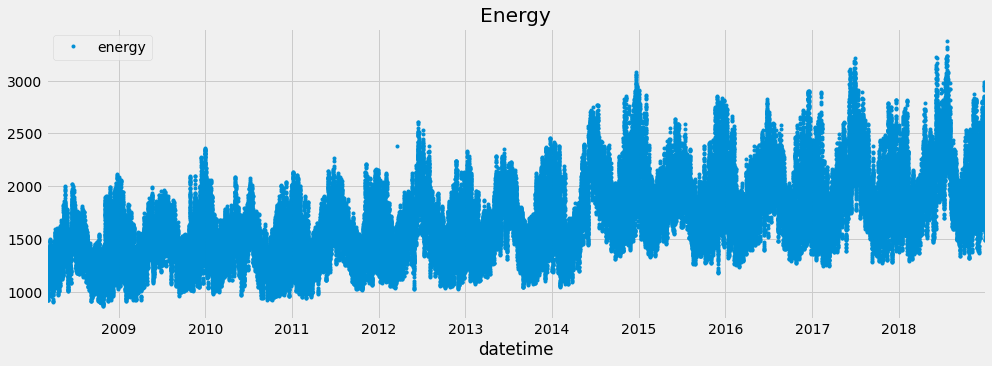

In [89]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy')
plt.show()

# 1. Outlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

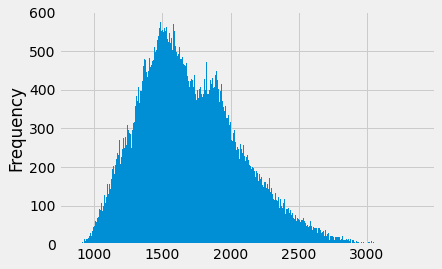

In [90]:
df['energy'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='datetime'>

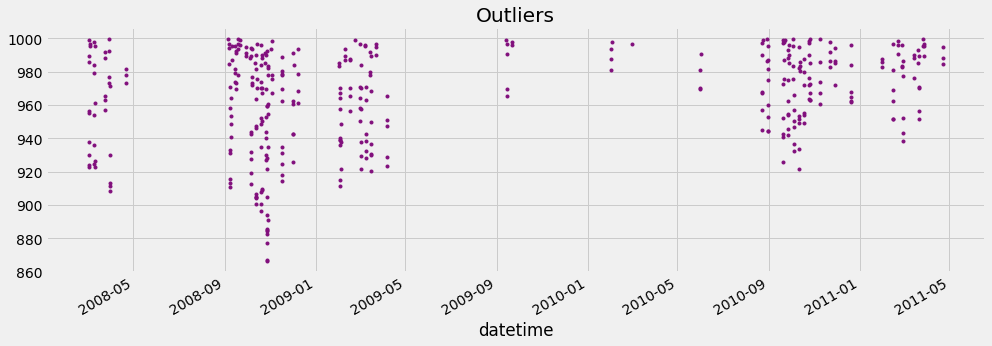

In [91]:
df.query('energy < 1_000')['energy'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [92]:
df.query('energy > 3_000')['energy'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

<AxesSubplot:title={'center':'Outliers'}, xlabel='datetime'>

In [93]:
df = df.query('energy > 1_000').copy()

In [94]:
df = df.query('energy < 3_000').copy()

# Reviewing: Train / Test Split

In [95]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [96]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [99]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['energy'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['energy'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [100]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features

In [101]:
def add_lags(df):
    target_map = df['energy'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('1456 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('1820 days')).map(target_map)
    df['lag6'] = (df.index - pd.Timedelta('2184 days')).map(target_map)
    df['lag7'] = (df.index - pd.Timedelta('2548 days')).map(target_map)
    df['lag8'] = (df.index - pd.Timedelta('2912 days')).map(target_map)
    return df

In [102]:
df = add_lags(df)

In [104]:
df.tail()

energy  hour  dayofweek  quarter  month  year  \
datetime                                                                
2018-12-31 19:00:00  2528.4468    19          0        4     12  2018   
2018-12-31 20:00:00  2461.8836    20          0        4     12  2018   
2018-12-31 21:00:00  2365.9944    21          0        4     12  2018   
2018-12-31 22:00:00  2342.9428    22          0        4     12  2018   
2018-12-31 23:00:00  2180.2176    23          0        4     12  2018   

                     dayofyear  dayofmonth  weekofyear       lag1       lag2  \
datetime                                                                       
2018-12-31 19:00:00        365          31           1  2142.5796  1957.0518   
2018-12-31 20:00:00        365          31           1  2102.3100  1901.7234   
2018-12-31 21:00:00        365          31           1  2049.0120  1867.3335   
2018-12-31 22:00:00        365          31           1  2045.4588  1857.4353   
2018-12-31 23:00:00        365          31           1  1921.2284  1759.2147   

                          lag3       lag4       lag5       lag6       lag7  \
datetime                                                                     
2018-12-31 19:00:00  2258.8670  2406.5944  1958.3508  2134.0830  1506.8250   
2018-12-31 20:00:00  2213.5308  2345.1212  1921.3656  2086.0952  1475.1900   
2018-12-31 21:00:00  2158.7852  2306.8100  1864.5928  2037.5789  1463.9050   
2018-12-31 22:00:00  2144.4878  2273.7572  1856.2012  2011.6824  1473.7100   
2018-12-31 23:00:00  2022.1656  2157.3212  1748.5608  1896.0466  1404.6125   

                          lag8  
datetime                        
2018-12-31 19:00:00  1801.9176  
2018-12-31 20:00:00  1757.5149  
2018-12-31 21:00:00  1721.2626  
2018-12-31 22:00:00  1707.5937  
2018-12-31 23:00:00  1602.8271

## Train Using Cross Validation

In [109]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'dayofmonth']
    TARGET = 'energy'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           max_depth=3,
                           learning_rate=0.03,
                          reg_lambda=1.2,
                          reg_alpha=1.1)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:1474.84430	validation_1-rmse:1811.29461
[100]	validation_0-rmse:159.18750	validation_1-rmse:343.69008
[200]	validation_0-rmse:129.91829	validation_1-rmse:284.88407
[300]	validation_0-rmse:124.43134	validation_1-rmse:279.07896
[400]	validation_0-rmse:120.12687	validation_1-rmse:277.37714
[500]	validation_0-rmse:116.82823	validation_1-rmse:276.28163
[600]	validation_0-rmse:113.80154	validation_1-rmse:275.13784
[700]	validation_0-rmse:111.51478	validation_1-rmse:274.15683
[800]	validation_0-rmse:109.36966	validation_1-rmse:273.87138
[827]	validation_0-rmse:108.81019	validation_1-rmse:273.49916
[0]	validation_0-rmse:1529.68136	validation_1-rmse:1886.70003
[100]	validation_0-rmse:168.10624	validation_1-rmse:255.77380
[185]	validation_0-rmse:136.69153	validation_1-rmse:247.66602
[0]	validation_0-rmse:1581.10432	validation_1-rmse:1882.95900
[100]	validation_0-rmse:175.35560	validation_1-rmse:179.97850
[172]	validation_0-rmse:144.58319	validation_1-rmse:179.65432
[0]	vali

In [110]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 219.3361
Fold scores:[273.29258654958124, 243.70604062831038, 173.501452213696, 206.5937610441458, 199.58669462947944]


# 4. Predicting the Future

In [111]:
df.tail()

energy  hour  dayofweek  quarter  month  year  \
datetime                                                                
2018-12-31 19:00:00  2528.4468    19          0        4     12  2018   
2018-12-31 20:00:00  2461.8836    20          0        4     12  2018   
2018-12-31 21:00:00  2365.9944    21          0        4     12  2018   
2018-12-31 22:00:00  2342.9428    22          0        4     12  2018   
2018-12-31 23:00:00  2180.2176    23          0        4     12  2018   

                     dayofyear  dayofmonth  weekofyear       lag1       lag2  \
datetime                                                                       
2018-12-31 19:00:00        365          31           1  2142.5796  1957.0518   
2018-12-31 20:00:00        365          31           1  2102.3100  1901.7234   
2018-12-31 21:00:00        365          31           1  2049.0120  1867.3335   
2018-12-31 22:00:00        365          31           1  2045.4588  1857.4353   
2018-12-31 23:00:00        365          31           1  1921.2284  1759.2147   

                          lag3       lag4       lag5       lag6       lag7  \
datetime                                                                     
2018-12-31 19:00:00  2258.8670  2406.5944  1958.3508  2134.0830  1506.8250   
2018-12-31 20:00:00  2213.5308  2345.1212  1921.3656  2086.0952  1475.1900   
2018-12-31 21:00:00  2158.7852  2306.8100  1864.5928  2037.5789  1463.9050   
2018-12-31 22:00:00  2144.4878  2273.7572  1856.2012  2011.6824  1473.7100   
2018-12-31 23:00:00  2022.1656  2157.3212  1748.5608  1896.0466  1404.6125   

                          lag8  
datetime                        
2018-12-31 19:00:00  1801.9176  
2018-12-31 20:00:00  1757.5149  
2018-12-31 21:00:00  1721.2626  
2018-12-31 22:00:00  1707.5937  
2018-12-31 23:00:00  1602.8271

In [114]:
# Retrain on all data
#df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'dayofmonth']
TARGET = 'energy'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',   
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           max_depth=3,
                           learning_rate=0.03,
                          reg_lambda=1.2,
                          reg_alpha=1.1)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:1691.05169
[100]	validation_0-rmse:188.66747
[200]	validation_0-rmse:157.67915
[300]	validation_0-rmse:152.78738
[400]	validation_0-rmse:148.86254
[500]	validation_0-rmse:145.85604
[600]	validation_0-rmse:142.89356
[700]	validation_0-rmse:140.50372
[800]	validation_0-rmse:138.43163
[900]	validation_0-rmse:135.98142
[999]	validation_0-rmse:133.44509


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1.1, reg_lambda=1.2, ...)

## Predict the future

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [115]:
future = pd.read_csv("../input/jobathon/test_WudNWDM.csv")
future.drop(['row_id'], axis=1, inplace=True)
future = future.set_index('datetime')
future.index = pd.to_datetime(future.index)
future

Empty DataFrame
Columns: []
Index: [2019-01-01 00:00:00, 2019-01-01 01:00:00, 2019-01-01 02:00:00, 2019-01-01 03:00:00, 2019-01-01 04:00:00, 2019-01-01 05:00:00, 2019-01-01 06:00:00, 2019-01-01 07:00:00, 2019-01-01 08:00:00, 2019-01-01 09:00:00, 2019-01-01 10:00:00, 2019-01-01 11:00:00, 2019-01-01 12:00:00, 2019-01-01 13:00:00, 2019-01-01 14:00:00, 2019-01-01 15:00:00, 2019-01-01 16:00:00, 2019-01-01 17:00:00, 2019-01-01 18:00:00, 2019-01-01 19:00:00, 2019-01-01 20:00:00, 2019-01-01 21:00:00, 2019-01-01 22:00:00, 2019-01-01 23:00:00, 2019-01-02 00:00:00, 2019-01-02 01:00:00, 2019-01-02 02:00:00, 2019-01-02 03:00:00, 2019-01-02 04:00:00, 2019-01-02 05:00:00, 2019-01-02 06:00:00, 2019-01-02 07:00:00, 2019-01-02 08:00:00, 2019-01-02 09:00:00, 2019-01-02 10:00:00, 2019-01-02 11:00:00, 2019-01-02 12:00:00, 2019-01-02 13:00:00, 2019-01-02 14:00:00, 2019-01-02 15:00:00, 2019-01-02 16:00:00, 2019-01-02 17:00:00, 2019-01-02 18:00:00, 2019-01-02 19:00:00, 2019-01-02 20:00:00, 2019-01-02 21:00:00, 2019-01-02 22:00:00, 2019-01-02 23:00:00, 2019-01-03 00:00:00, 2019-01-03 01:00:00, 2019-01-03 02:00:00, 2019-01-03 03:00:00, 2019-01-03 04:00:00, 2019-01-03 05:00:00, 2019-01-03 06:00:00, 2019-01-03 07:00:00, 2019-01-03 08:00:00, 2019-01-03 09:00:00, 2019-01-03 10:00:00, 2019-01-03 11:00:00, 2019-01-03 12:00:00, 2019-01-03 13:00:00, 2019-01-03 14:00:00, 2019-01-03 15:00:00, 2019-01-03 16:00:00, 2019-01-03 17:00:00, 2019-01-03 18:00:00, 2019-01-03 19:00:00, 2019-01-03 20:00:00, 2019-01-03 21:00:00, 2019-01-03 22:00:00, 2019-01-03 23:00:00, 2019-01-04 00:00:00, 2019-01-04 01:00:00, 2019-01-04 02:00:00, 2019-01-04 03:00:00, 2019-01-04 04:00:00, 2019-01-04 05:00:00, 2019-01-04 06:00:00, 2019-01-04 07:00:00, 2019-01-04 08:00:00, 2019-01-04 09:00:00, 2019-01-04 10:00:00, 2019-01-04 11:00:00, 2019-01-04 12:00:00, 2019-01-04 13:00:00, 2019-01-04 14:00:00, 2019-01-04 15:00:00, 2019-01-04 16:00:00, 2019-01-04 17:00:00, 2019-01-04 18:00:00, 2019-01-04 19:00:00, 2019-01-04 20:00:00, 2019-01-04 21:00:00, 2019-01-04 22:00:00, 2019-01-04 23:00:00, 2019-01-05 00:00:00, 2019-01-05 01:00:00, 2019-01-05 02:00:00, 2019-01-05 03:00:00, ...]

[26304 rows x 0 columns]

In [116]:
future['isFuture'] = True
df['isFuture'] = False
df_and_future = df.append(future)
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [117]:
df_and_future

energy  hour  dayofweek  quarter  month  year  \
datetime                                                                  
2008-03-01 00:00:00  1259.985563     0          5        1      3  2008   
2008-03-01 01:00:00  1095.541500     1          5        1      3  2008   
2008-03-01 02:00:00  1056.247500     2          5        1      3  2008   
2008-03-01 03:00:00  1034.742000     3          5        1      3  2008   
2008-03-01 04:00:00  1026.334500     4          5        1      3  2008   
...                          ...   ...        ...      ...    ...   ...   
2021-12-31 19:00:00          NaN    19          4        4     12  2021   
2021-12-31 20:00:00          NaN    20          4        4     12  2021   
2021-12-31 21:00:00          NaN    21          4        4     12  2021   
2021-12-31 22:00:00          NaN    22          4        4     12  2021   
2021-12-31 23:00:00          NaN    23          4        4     12  2021   

                     dayofyear  dayofmonth  weekofyear  lag1  lag2  lag3  \
datetime                                                                   
2008-03-01 00:00:00         61           1           9   NaN   NaN   NaN   
2008-03-01 01:00:00         61           1           9   NaN   NaN   NaN   
2008-03-01 02:00:00         61           1           9   NaN   NaN   NaN   
2008-03-01 03:00:00         61           1           9   NaN   NaN   NaN   
2008-03-01 04:00:00         61           1           9   NaN   NaN   NaN   
...                        ...         ...         ...   ...   ...   ...   
2021-12-31 19:00:00        365          31          52   NaN   NaN   NaN   
2021-12-31 20:00:00        365          31          52   NaN   NaN   NaN   
2021-12-31 21:00:00        365          31          52   NaN   NaN   NaN   
2021-12-31 22:00:00        365          31          52   NaN   NaN   NaN   
2021-12-31 23:00:00        365          31          52   NaN   NaN   NaN   

                          lag4       lag5       lag6       lag7       lag8  \
datetime                                                                     
2008-03-01 00:00:00        NaN        NaN        NaN        NaN        NaN   
2008-03-01 01:00:00        NaN        NaN        NaN        NaN        NaN   
2008-03-01 02:00:00        NaN        NaN        NaN        NaN        NaN   
2008-03-01 03:00:00        NaN        NaN        NaN        NaN        NaN   
2008-03-01 04:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  2353.5344  2302.3467  2401.2300  2336.6076  2350.5804   
2021-12-31 20:00:00  2264.3096  2258.5662  2311.6574  2266.4956  2291.9428   
2021-12-31 21:00:00  2218.1180  2238.3891  2281.8406  2222.3000  2227.8144   
2021-12-31 22:00:00  2191.1400  2234.2014  2230.7610  2185.1156  2201.8108   
2021-12-31 23:00:00  2027.4296  2102.2254  2086.8094  2052.9044  2051.7980   

                     isFuture  
datetime                       
2008-03-01 00:00:00     False  
2008-03-01 01:00:00     False  
2008-03-01 02:00:00     False  
2008-03-01 03:00:00     False  
2008-03-01 04:00:00     False  
...                       ...  
2021-12-31 19:00:00      True  
2021-12-31 20:00:00      True  
2021-12-31 21:00:00      True  
2021-12-31 22:00:00      True  
2021-12-31 23:00:00      True  

[118912 rows x 18 columns]

In [118]:
an = pd.concat([df, future])
fu = df_and_future.query('isFuture').copy()

In [119]:
fu

energy  hour  dayofweek  quarter  month  year  dayofyear  \
datetime                                                                        
2019-01-01 00:00:00     NaN     0          1        1      1  2019          1   
2019-01-01 01:00:00     NaN     1          1        1      1  2019          1   
2019-01-01 02:00:00     NaN     2          1        1      1  2019          1   
2019-01-01 03:00:00     NaN     3          1        1      1  2019          1   
2019-01-01 04:00:00     NaN     4          1        1      1  2019          1   
...                     ...   ...        ...      ...    ...   ...        ...   
2021-12-31 19:00:00     NaN    19          4        4     12  2021        365   
2021-12-31 20:00:00     NaN    20          4        4     12  2021        365   
2021-12-31 21:00:00     NaN    21          4        4     12  2021        365   
2021-12-31 22:00:00     NaN    22          4        4     12  2021        365   
2021-12-31 23:00:00     NaN    23          4        4     12  2021        365   

                     dayofmonth  weekofyear       lag1       lag2       lag3  \
datetime                                                                       
2019-01-01 00:00:00           1           1  1778.7056  1634.8527  1884.8128   
2019-01-01 01:00:00           1           1  1666.9772  1553.6367  1771.9000   
2019-01-01 02:00:00           1           1  1580.7792  1469.7558  1675.1176   
2019-01-01 03:00:00           1           1  1523.1384  1440.9495  1623.6714   
2019-01-01 04:00:00           1           1  1513.2684  1432.1934  1587.6224   
...                         ...         ...        ...        ...        ...   
2021-12-31 19:00:00          31          52        NaN        NaN        NaN   
2021-12-31 20:00:00          31          52        NaN        NaN        NaN   
2021-12-31 21:00:00          31          52        NaN        NaN        NaN   
2021-12-31 22:00:00          31          52        NaN        NaN        NaN   
2021-12-31 23:00:00          31          52        NaN        NaN        NaN   

                          lag4       lag5       lag6       lag7       lag8  \
datetime                                                                     
2019-01-01 00:00:00  2018.7248  1614.7096  1744.3671  1317.7550  1472.8452   
2019-01-01 01:00:00  1894.1508  1512.8708  1631.3738  1225.5325  1382.9361   
2019-01-01 02:00:00  1807.8880  1432.6844  1547.0252  1178.1725  1306.2714   
2019-01-01 03:00:00        NaN  1389.8976  1490.5814  1149.1275  1260.9348   
2019-01-01 04:00:00  1711.7344  1354.6736  1446.8216  1149.2200  1234.0215   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  2353.5344  2302.3467  2401.2300  2336.6076  2350.5804   
2021-12-31 20:00:00  2264.3096  2258.5662  2311.6574  2266.4956  2291.9428   
2021-12-31 21:00:00  2218.1180  2238.3891  2281.8406  2222.3000  2227.8144   
2021-12-31 22:00:00  2191.1400  2234.2014  2230.7610  2185.1156  2201.8108   
2021-12-31 23:00:00  2027.4296  2102.2254  2086.8094  2052.9044  2051.7980   

                     isFuture  
datetime                       
2019-01-01 00:00:00      True  
2019-01-01 01:00:00      True  
2019-01-01 02:00:00      True  
2019-01-01 03:00:00      True  
2019-01-01 04:00:00      True  
...                       ...  
2021-12-31 19:00:00      True  
2021-12-31 20:00:00      True  
2021-12-31 21:00:00      True  
2021-12-31 22:00:00      True  
2021-12-31 23:00:00      True  

[26304 rows x 18 columns]

In [120]:
fu['pred'] = reg.predict(fu[FEATURES])

In [121]:
fu['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [122]:
fu

energy  hour  dayofweek  quarter  month  year  dayofyear  \
datetime                                                                        
2019-01-01 00:00:00     NaN     0          1        1      1  2019          1   
2019-01-01 01:00:00     NaN     1          1        1      1  2019          1   
2019-01-01 02:00:00     NaN     2          1        1      1  2019          1   
2019-01-01 03:00:00     NaN     3          1        1      1  2019          1   
2019-01-01 04:00:00     NaN     4          1        1      1  2019          1   
...                     ...   ...        ...      ...    ...   ...        ...   
2021-12-31 19:00:00     NaN    19          4        4     12  2021        365   
2021-12-31 20:00:00     NaN    20          4        4     12  2021        365   
2021-12-31 21:00:00     NaN    21          4        4     12  2021        365   
2021-12-31 22:00:00     NaN    22          4        4     12  2021        365   
2021-12-31 23:00:00     NaN    23          4        4     12  2021        365   

                     dayofmonth  weekofyear       lag1       lag2       lag3  \
datetime                                                                       
2019-01-01 00:00:00           1           1  1778.7056  1634.8527  1884.8128   
2019-01-01 01:00:00           1           1  1666.9772  1553.6367  1771.9000   
2019-01-01 02:00:00           1           1  1580.7792  1469.7558  1675.1176   
2019-01-01 03:00:00           1           1  1523.1384  1440.9495  1623.6714   
2019-01-01 04:00:00           1           1  1513.2684  1432.1934  1587.6224   
...                         ...         ...        ...        ...        ...   
2021-12-31 19:00:00          31          52        NaN        NaN        NaN   
2021-12-31 20:00:00          31          52        NaN        NaN        NaN   
2021-12-31 21:00:00          31          52        NaN        NaN        NaN   
2021-12-31 22:00:00          31          52        NaN        NaN        NaN   
2021-12-31 23:00:00          31          52        NaN        NaN        NaN   

                          lag4       lag5       lag6       lag7       lag8  \
datetime                                                                     
2019-01-01 00:00:00  2018.7248  1614.7096  1744.3671  1317.7550  1472.8452   
2019-01-01 01:00:00  1894.1508  1512.8708  1631.3738  1225.5325  1382.9361   
2019-01-01 02:00:00  1807.8880  1432.6844  1547.0252  1178.1725  1306.2714   
2019-01-01 03:00:00        NaN  1389.8976  1490.5814  1149.1275  1260.9348   
2019-01-01 04:00:00  1711.7344  1354.6736  1446.8216  1149.2200  1234.0215   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  2353.5344  2302.3467  2401.2300  2336.6076  2350.5804   
2021-12-31 20:00:00  2264.3096  2258.5662  2311.6574  2266.4956  2291.9428   
2021-12-31 21:00:00  2218.1180  2238.3891  2281.8406  2222.3000  2227.8144   
2021-12-31 22:00:00  2191.1400  2234.2014  2230.7610  2185.1156  2201.8108   
2021-12-31 23:00:00  2027.4296  2102.2254  2086.8094  2052.9044  2051.7980   

                     isFuture         pred  
datetime                                    
2019-01-01 00:00:00      True  1872.587158  
2019-01-01 01:00:00      True  1803.174072  
2019-01-01 02:00:00      True  1679.086792  
2019-01-01 03:00:00      True  1592.834961  
2019-01-01 04:00:00      True  1603.809570  
...                       ...          ...  
2021-12-31 19:00:00      True  2478.809570  
2021-12-31 20:00:00      True  2464.828369  
2021-12-31 21:00:00      True  2464.828369  
2021-12-31 22:00:00      True  2444.866699  
2021-12-31 23:00:00      True  2326.042969  

[26304 rows x 19 columns]

In [123]:
fu['row_id'] = range(94993, 94993+len(fu))

In [124]:
fu

energy  hour  dayofweek  quarter  month  year  dayofyear  \
datetime                                                                        
2019-01-01 00:00:00     NaN     0          1        1      1  2019          1   
2019-01-01 01:00:00     NaN     1          1        1      1  2019          1   
2019-01-01 02:00:00     NaN     2          1        1      1  2019          1   
2019-01-01 03:00:00     NaN     3          1        1      1  2019          1   
2019-01-01 04:00:00     NaN     4          1        1      1  2019          1   
...                     ...   ...        ...      ...    ...   ...        ...   
2021-12-31 19:00:00     NaN    19          4        4     12  2021        365   
2021-12-31 20:00:00     NaN    20          4        4     12  2021        365   
2021-12-31 21:00:00     NaN    21          4        4     12  2021        365   
2021-12-31 22:00:00     NaN    22          4        4     12  2021        365   
2021-12-31 23:00:00     NaN    23          4        4     12  2021        365   

                     dayofmonth  weekofyear       lag1       lag2       lag3  \
datetime                                                                       
2019-01-01 00:00:00           1           1  1778.7056  1634.8527  1884.8128   
2019-01-01 01:00:00           1           1  1666.9772  1553.6367  1771.9000   
2019-01-01 02:00:00           1           1  1580.7792  1469.7558  1675.1176   
2019-01-01 03:00:00           1           1  1523.1384  1440.9495  1623.6714   
2019-01-01 04:00:00           1           1  1513.2684  1432.1934  1587.6224   
...                         ...         ...        ...        ...        ...   
2021-12-31 19:00:00          31          52        NaN        NaN        NaN   
2021-12-31 20:00:00          31          52        NaN        NaN        NaN   
2021-12-31 21:00:00          31          52        NaN        NaN        NaN   
2021-12-31 22:00:00          31          52        NaN        NaN        NaN   
2021-12-31 23:00:00          31          52        NaN        NaN        NaN   

                          lag4       lag5       lag6       lag7       lag8  \
datetime                                                                     
2019-01-01 00:00:00  2018.7248  1614.7096  1744.3671  1317.7550  1472.8452   
2019-01-01 01:00:00  1894.1508  1512.8708  1631.3738  1225.5325  1382.9361   
2019-01-01 02:00:00  1807.8880  1432.6844  1547.0252  1178.1725  1306.2714   
2019-01-01 03:00:00        NaN  1389.8976  1490.5814  1149.1275  1260.9348   
2019-01-01 04:00:00  1711.7344  1354.6736  1446.8216  1149.2200  1234.0215   
...                        ...        ...        ...        ...        ...   
2021-12-31 19:00:00  2353.5344  2302.3467  2401.2300  2336.6076  2350.5804   
2021-12-31 20:00:00  2264.3096  2258.5662  2311.6574  2266.4956  2291.9428   
2021-12-31 21:00:00  2218.1180  2238.3891  2281.8406  2222.3000  2227.8144   
2021-12-31 22:00:00  2191.1400  2234.2014  2230.7610  2185.1156  2201.8108   
2021-12-31 23:00:00  2027.4296  2102.2254  2086.8094  2052.9044  2051.7980   

                     isFuture         pred  row_id  
datetime                                            
2019-01-01 00:00:00      True  1872.587158   94993  
2019-01-01 01:00:00      True  1803.174072   94994  
2019-01-01 02:00:00      True  1679.086792   94995  
2019-01-01 03:00:00      True  1592.834961   94996  
2019-01-01 04:00:00      True  1603.809570   94997  
...                       ...          ...     ...  
2021-12-31 19:00:00      True  2478.809570  121292  
2021-12-31 20:00:00      True  2464.828369  121293  
2021-12-31 21:00:00      True  2464.828369  121294  
2021-12-31 22:00:00      True  2444.866699  121295  
2021-12-31 23:00:00      True  2326.042969  121296  

[26304 rows x 20 columns]

In [125]:
submit = fu.loc[:, ['row_id', 'pred']]

In [126]:
submit

row_id         pred
datetime                                
2019-01-01 00:00:00   94993  1872.587158
2019-01-01 01:00:00   94994  1803.174072
2019-01-01 02:00:00   94995  1679.086792
2019-01-01 03:00:00   94996  1592.834961
2019-01-01 04:00:00   94997  1603.809570
...                     ...          ...
2021-12-31 19:00:00  121292  2478.809570
2021-12-31 20:00:00  121293  2464.828369
2021-12-31 21:00:00  121294  2464.828369
2021-12-31 22:00:00  121295  2444.866699
2021-12-31 23:00:00  121296  2326.042969

[26304 rows x 2 columns]

In [127]:
submit.reset_index(inplace = True, drop = True)

In [128]:
submit

row_id         pred
0       94993  1872.587158
1       94994  1803.174072
2       94995  1679.086792
3       94996  1592.834961
4       94997  1603.809570
...       ...          ...
26299  121292  2478.809570
26300  121293  2464.828369
26301  121294  2464.828369
26302  121295  2444.866699
26303  121296  2326.042969

[26304 rows x 2 columns]

In [129]:
submit.rename(columns = {'pred':'energy', 'row_id':'row_id'}, inplace=True)

In [130]:
submit.set_index(['row_id'], inplace = True)

In [131]:
submit

energy
row_id             
94993   1872.587158
94994   1803.174072
94995   1679.086792
94996   1592.834961
94997   1603.809570
...             ...
121292  2478.809570
121293  2464.828369
121294  2464.828369
121295  2444.866699
121296  2326.042969

[26304 rows x 1 columns]

In [132]:
submit.to_csv('submission3.csv')

In [133]:
nm = pd.read_csv('./submission3.csv')

In [134]:
nm

row_id     energy
0       94993  1872.5872
1       94994  1803.1741
2       94995  1679.0868
3       94996  1592.8350
4       94997  1603.8096
...       ...        ...
26299  121292  2478.8096
26300  121293  2464.8284
26301  121294  2464.8284
26302  121295  2444.8667
26303  121296  2326.0430

[26304 rows x 2 columns]

In [254]:
mn = pd.read_csv("../input/jobathon/sample_submission_jn0a7vR.csv")

In [255]:
mn

row_id       energy
0       94993  1702.995014
1       94994  1702.995014
2       94995  1702.995014
3       94996  1702.995014
4       94997  1702.995014
...       ...          ...
26299  121292  1702.995014
26300  121293  1702.995014
26301  121294  1702.995014
26302  121295  1702.995014
26303  121296  1702.995014

[26304 rows x 2 columns]